In [1]:
import os

import pandas as pd
import torch
import torch.nn as nn
from datasets import Dataset
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoConfig
from transformers import AutoModel, AutoTokenizer
from transformers import Trainer, TrainingArguments
import json

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

C:\Users\nishi\PythonProject\ImageForensics\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
def get_company_dataset(company, tokenizer, max_length=64, test_size=0.2):
    df = pd.read_csv(f"{company}.csv")

    #  Label Encoding (Local to this company/dataset)
    # If global consistency needed across companies, pass fitted encoders instead.
    type_encoder = LabelEncoder()
    code_encoder = LabelEncoder()

    df['cc_type_id'] = type_encoder.fit_transform(df['cc_type'])
    df['cc_code_id'] = code_encoder.fit_transform(df['cc_code'])

    type_id_to_label = {str(i): str(label) for i, label in enumerate(type_encoder.classes_)}
    code_id_to_label = {str(i): str(label) for i, label in enumerate(code_encoder.classes_)}

    with open(f'type_id_to_label_{company}.json', 'w') as f:
        json.dump(type_id_to_label, f)

    with open(f'code_id_to_label_{company}.json', 'w') as f:
        json.dump(code_id_to_label, f)

    # Calculate dimensions for the model heads
    num_type_labels = len(type_encoder.classes_)
    num_code_labels = len(code_encoder.classes_)

    print(f"Dataset Loaded: {len(df)} records")
    print(f"Found {num_type_labels} Transaction Types and {num_code_labels} GL Codes.")

    # 3. Stratified Train/Test Split
    # We create a temporary 'stratify_col' to ensure both Type and Code distributions are preserved
    df['stratify_col'] = df['cc_type'].astype(str) + "_" + df['cc_code'].astype(str)

    train_df, val_df = train_test_split(
        df,
        test_size=test_size,
        random_state=42,
        stratify=df['stratify_col']  # Critical for rare GL codes
    )

    train_df.to_csv(f"Training_Data_{company}.csv", index=False)
    val_df.to_csv(f"Val_Data_{company}.csv", index=False)

    val_metadata = val_df[['merchant_name', 'merchant_group', 'cc_type', 'cc_code']].reset_index(drop=True)

    # Cleanup auxiliary columns
    cols_to_keep = ['merchant_group', 'merchant_name', 'cc_type_id', 'cc_code_id']
    train_df = train_df[cols_to_keep]
    val_df = val_df[cols_to_keep]

    # 4. Convert to Hugging Face Datasets
    train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
    val_dataset = Dataset.from_pandas(val_df, preserve_index=False)

    # 5. Tokenization Function
    def preprocess_function(examples):
        # Manual concatenation for Qwen/LLMs
        inputs = [f"{g} | {n}" for g, n in zip(examples["merchant_group"], examples["merchant_name"])]

        tokenized_inputs = tokenizer(
            inputs,  # Single list of strings
            truncation=True,
            max_length=max_length,
            padding="max_length"  # Or False if using DataCollator
        )

        tokenized_inputs["labels_type"] = examples["cc_type_id"]
        tokenized_inputs["labels_code"] = examples["cc_code_id"]
        return tokenized_inputs

    # 6. Apply Processing
    # We remove the text columns to leave only the tensors
    remove_cols = train_dataset.column_names

    train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=remove_cols)
    val_dataset = val_dataset.map(preprocess_function, batched=True, remove_columns=remove_cols)

    # 7. Set Format for PyTorch
    target_columns = ["input_ids", "attention_mask", "labels_type", "labels_code"]
    train_dataset.set_format(type="torch", columns=target_columns)
    val_dataset.set_format(type="torch", columns=target_columns)

    return {
        "train": train_dataset,
        "val": val_dataset,
        "val_metadata": val_metadata,
        "num_type_labels": num_type_labels,
        "num_code_labels": num_code_labels,
        "encoders": {"type": type_encoder, "code": code_encoder}

    }


In [3]:
class QwenMultiHeadClassifier(nn.Module):
    def __init__(self, model_id, num_type_labels, num_code_labels, lora_config=None):
        super().__init__()
        self.config = AutoConfig.from_pretrained(model_id)
        self.qwen = AutoModel.from_pretrained(
            model_id,
            #allows the library to download and execute custom Python code found in the model's Hugging Face Hub repository, 
            #rather than using the standard code built into the transformers librar
            trust_remote_code=True,
            device_map=None  # CUDA
        )

        # print(f"VANILLA QWEN ARCHITECTURE : \n {self.qwen}")

        if lora_config is not None:
            self.qwen = get_peft_model(self.qwen, lora_config)

            self.qwen.print_trainable_parameters()

        # Two separate Head for Code and Type , hiodeen size of model , 1536 for Qwen .

        self.type_head = nn.Linear(self.config.hidden_size, num_type_labels)
        self.code_head = nn.Linear(self.config.hidden_size, num_code_labels)

        # changing heads added to QWEN Data Type DFloat16 
        self.type_head.to(self.qwen.dtype)
        self.code_head.to(self.qwen.dtype)

        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask=None,
                labels_type=None, labels_code=None, labels=None, **kwargs):

        if labels is not None:
            labels_type = labels[:, 0]  # Assuming first col is type
            labels_code = labels[:, 1]  # Assuming second col is code

        outputs = self.qwen(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
            return_dict=True
        )
        # Extract Last Token Embedding (EOS token), for LLMs, use Last Hidden State of last token
        # shape : [batch, seq_length, hidden]
        last_hidden_state = outputs.last_hidden_state
        #print( "Shape of last hidden state %",last_hidden_state.shape )
        #Shape of last hidden state = torch.Size([32, 64, 1536])
        # Get Embedding of last token for Classification
        if self.config.pad_token_id is None:  # Fallback if no pad token
            sequence_lengths = -1
        else:
            if input_ids is not None:  # Find last non paddign token
                sequence_lengths = (torch.ne(input_ids, self.config.pad_token_id).sum(-1) - 1).to(
                    last_hidden_state.device)
            else:
                sequence_lengths = -1

        # Get the Vector for last token in the sequence using sequence lenght calced above
        #last_hidden_state shape: (Batch_Size, Sequence_Length, Hidden_Size)
        # last_hidden_state[0] = batch size
        # sequence_lengths contains last token indexes for each sequence .
        # Last token is sequence is like CLS token it has learnt about the sequence
        pooled_output = last_hidden_state[torch.arange(last_hidden_state.shape[0]), sequence_lengths]

        # Pass it tot he linear layers like we do CLS Token in Transforemrs
        logits_type = self.type_head(pooled_output)
        logits_code = self.code_head(pooled_output)

        loss = None

        if labels_type is not None and labels_code is not None:
            loss_type = self.loss_fn(logits_type, labels_type)
            loss_code = self.loss_fn(logits_code, labels_code)
            loss = 2 * loss_type + 1 * loss_code
        else:
            loss = torch.tensor(0.0, device=input_ids.device, requires_grad=True)

        # Form output that can work with Huggingface trainer
        output = {
            "logits": (logits_type, logits_code)
        }

        return {
            "loss": loss,
            "logits": (logits_type, logits_code),
            # Trainer accepts tuples here if you handle them in compute_metrics
            "hidden_states": outputs.hidden_states,
            "attentions": outputs.attentions,
        }



In [4]:
class CustomTrainer(Trainer):
    def save_model(self, output_dir=None, _internal_call=False):
        # Save the LoRA adapters (standard behavior)
        # Checks if model is wrapped in PEFT
        if output_dir is None:
            output_dir = self.args.output_dir

        # Save LoRA weights
        self.model.qwen.save_pretrained(output_dir)

        # MANUALLY save your custom heads
        torch.save(self.model.type_head.state_dict(), f"{output_dir}/type_head.bin")
        torch.save(self.model.code_head.state_dict(), f"{output_dir}/code_head.bin")

        # Save tokenizer
        self.tokenizer.save_pretrained(output_dir)



In [5]:
model_id = "Qwen/Qwen2.5-1.5B"

tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

companies = ["company_D", "company_E", "company_F"]  #  list of companies,  "company_E", "company_F"

data_bundle_company_D = get_company_dataset("company_D", tokenizer)
data_bundle_company_E = get_company_dataset("company_E", tokenizer)
data_bundle_company_F = get_company_dataset("company_F", tokenizer)


import joblib

# ... (inside your training loop, after creating data_bundle) ...
print(f"Saving data bundle for companies...")
joblib.dump(data_bundle_company_D, "data_bundle_company_D.pkl")
joblib.dump(data_bundle_company_E, "data_bundle_company_E.pkl")
joblib.dump(data_bundle_company_F, "data_bundle_company_F.pkl")

peft_config = LoraConfig(
    #treat the Qwen backbone as a feature extractor.as we have custom multihead QWEN ,
    # normal classification this would have been SEQ_CLS
    # classification heads are external to the PEFT wrapper here
    task_type=TaskType.FEATURE_EXTRACTION,
    r=16,  # 16 RANk is good , LORA Mattrices will be A X R and R X B .
    lora_alpha=32,
    # Scales Output of Lora adapter by Alpha / Rank . ( 32/16 for us) , Makes learnt weights LOUDER compared to base model weights .
    #Scale of 2 is good .
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    # Q K V and Output Projections selected to train as part of adapter
    # MLP Layers are gate_proj, up_proj, down_proj , but results in very large number of paramters to learn but also gives huge accuracy benefit .
    lora_dropout=0.05  # Prevents overfittig whern data sizes are small like our company data case.
)

Dataset Loaded: 10000 records
Found 14 Transaction Types and 26 GL Codes.


Map: 100%|██████████| 2000/2000 [00:00<00:00, 59128.84 examples/s]


Dataset Loaded: 10000 records
Found 12 Transaction Types and 25 GL Codes.


Map: 100%|██████████| 2000/2000 [00:00<00:00, 44906.90 examples/s]


Dataset Loaded: 10000 records
Found 13 Transaction Types and 27 GL Codes.


Map: 100%|██████████| 2000/2000 [00:00<00:00, 56582.29 examples/s]

Saving data bundle for companies...


In [6]:

# 4. Training Loop
for company in companies:
    print(f"Training adapter for: {company}")
    # Format: "Merchant Group: {grp} [SEP] Merchant Name: {name}"
    if company == "company_D":
        data_bundle = data_bundle_company_D
    elif company == "company_E":
        data_bundle = data_bundle_company_E
    elif company == "company_F":
        data_bundle = data_bundle_company_F

    train_dataset = data_bundle["train"]
    val_dataset = data_bundle["val"]
    num_type_labels = data_bundle["num_type_labels"]
    num_code_labels = data_bundle["num_code_labels"]

    model = QwenMultiHeadClassifier(
        model_id=model_id,
        num_type_labels=num_type_labels,
        num_code_labels=num_code_labels,
        lora_config=peft_config
    )

    model.qwen.resize_token_embeddings(len(tokenizer))

    for param in model.type_head.parameters(): param.requires_grad = True
    for param in model.code_head.parameters(): param.requires_grad = True

    # C. Train
    training_args = TrainingArguments(
        output_dir=f"./results/{company}",
        per_device_train_batch_size=32,
        num_train_epochs=3,
        save_strategy="no",  # We save manually to be safe
        learning_rate=2e-4,
        remove_unused_columns=False  # Important for custom models
    )

    custom_trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset
    )

    custom_trainer.train()

    metrics = custom_trainer.evaluate(eval_dataset=val_dataset)
    print(metrics)

    save_path = f"./final_adapters_QWEN/{company}"

    # Save Adapter & Heads
    # This saves the LoRA weights
    model.qwen.save_pretrained(save_path)
    torch.save(model.type_head.state_dict(), os.path.join(save_path, "type_head.bin"))
    torch.save(model.code_head.state_dict(), os.path.join(save_path, "code_head.bin"))

     # 6. Clean up
    del model
    torch.cuda.empty_cache()


Training adapter for: company_D


Loading weights: 100%|██████████| 338/338 [00:00<00:00, 1440.07it/s, Materializing param=norm.weight]                              


trainable params: 4,358,144 || all params: 1,548,072,448 || trainable%: 0.2815


Step,Training Loss
500,1.454544


{'eval_runtime': 43.7539, 'eval_samples_per_second': 45.71, 'eval_steps_per_second': 5.714, 'epoch': 3.0}


C:\Users\nishi\PythonProject\ImageForensics\.venv\Lib\site-packages\peft\utils\save_and_load.py:309: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Training adapter for: company_E


Loading weights: 100%|██████████| 338/338 [00:00<00:00, 1242.60it/s, Materializing param=norm.weight]                              


trainable params: 4,358,144 || all params: 1,548,072,448 || trainable%: 0.2815


Step,Training Loss
500,1.418134


{'eval_runtime': 85.2286, 'eval_samples_per_second': 23.466, 'eval_steps_per_second': 2.933, 'epoch': 3.0}
Training adapter for: company_F


Loading weights: 100%|██████████| 338/338 [00:00<00:00, 1392.69it/s, Materializing param=norm.weight]                              


trainable params: 4,358,144 || all params: 1,548,072,448 || trainable%: 0.2815


Step,Training Loss
500,1.690554


{'eval_runtime': 17.6965, 'eval_samples_per_second': 113.017, 'eval_steps_per_second': 14.127, 'epoch': 3.0}


In [7]:
model_id = "Qwen/Qwen2.5-1.5B"

tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token
peft_config = LoraConfig(
    #treat the Qwen backbone as a feature extractor.as we have custom multihead QWEN ,
    # normal classification this would have been SEQ_CLS
    # classification heads are external to the PEFT wrapper here
    task_type=TaskType.FEATURE_EXTRACTION,
    r=16,  # 16 RANk is good , LORA Mattrices will be A X R and R X B .
    lora_alpha=32,
    # Scales Output of Lora adapter by Alpha / Rank . ( 32/16 for us) , Makes learnt weights LOUDER compared to base model weights .
    #Scale of 2 is good .
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    # Q K V and Output Projections selected to train as part of adapter
    # MLP Layers are gate_proj, up_proj, down_proj , but results in very large number of paramters to learn but also gives huge accuracy benefit .
    lora_dropout=0.05  # Prevents overfittig whern data sizes are small like our company data case.
)

Loading Base Model (this takes time)...


Loading weights: 100%|██████████| 338/338 [00:00<00:00, 1255.51it/s, Materializing param=norm.weight]                              


Fetching data for company_D...
Loading cached data bundle for company_D...

--- Validating: company_D ---
Loading heads -> Types: 14, Codes: 26
Running Inference...


✅ Predictions saved to: predictions_company_D.csv

--- Prediction Sample for company_D ---
Idx   Merchant                       Act. Code            Pred. Code           Match
-------------------------------------------------------------------------------------
0     Russell, Martinez and Taylor   34062                34062                ✅    
1     Morris Ltd qql                 39641                39641                ✅    
2     Ford, Sims and Gilbert lnf     35634                35634                ✅    
3     Moore-Osborne afw              35634                35634                ✅    
4     Reese Ltd czc                  34965                34965                ✅    
5     Curtis-Taylor xzo              33319                33319                ✅    
6     Robinson-Bryant uon            37644                37644                ✅    
7     Stephens, Melton and Grimes    33145                33145                ✅    
8     Logan PLC efq                  33319                

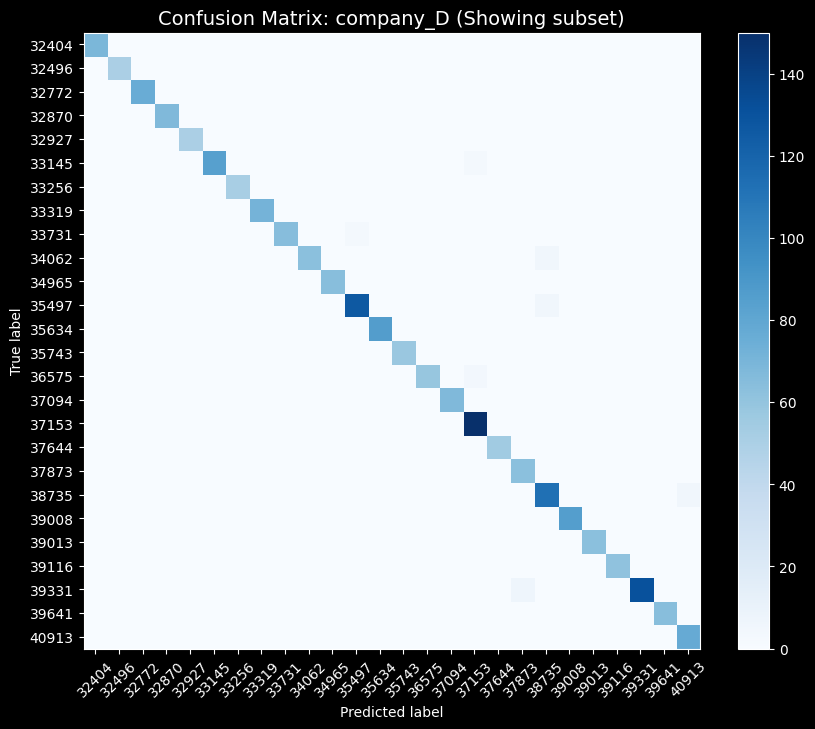

Generating Confusion Matrix for GL Types...


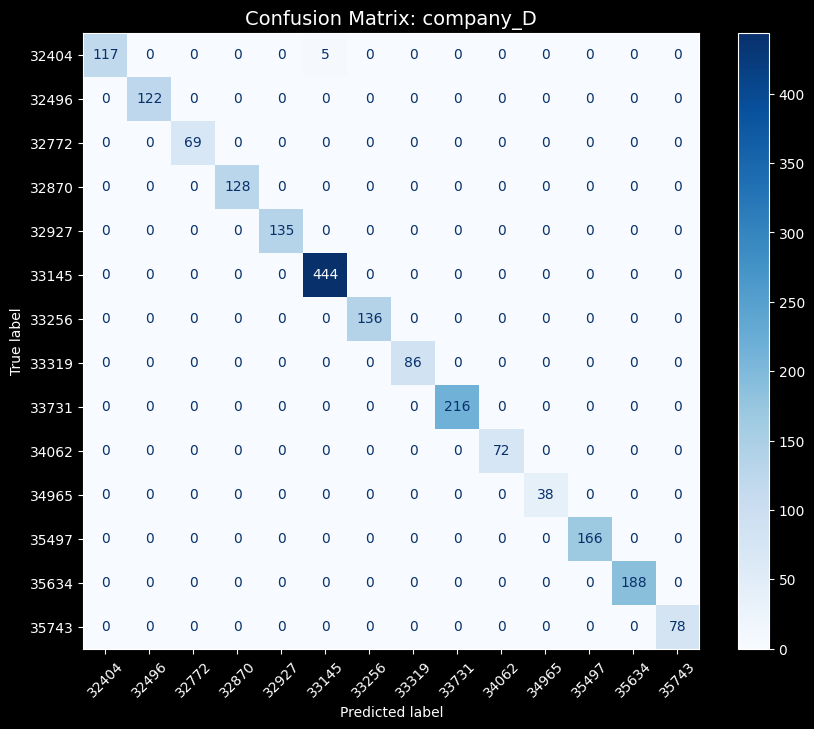

Fetching data for company_E...
Loading cached data bundle for company_E...

--- Validating: company_E ---
Loading heads -> Types: 12, Codes: 25


C:\Users\nishi\PythonProject\ImageForensics\.venv\Lib\site-packages\peft\tuners\tuners_utils.py:1466: UserWarning: Adapter company_D was active which is now deleted. Setting active adapter to default.
  warnings.warn(


Running Inference...


✅ Predictions saved to: predictions_company_E.csv

--- Prediction Sample for company_E ---
Idx   Merchant                       Act. Code            Pred. Code           Match
-------------------------------------------------------------------------------------
0     Paul-Saunders mbh              20636                20636                ✅    
1     Wood LLC uft                   26002                26002                ✅    
2     Garcia PLC chl                 28867                28867                ✅    
3     Werner-Cohen krp               23883                23883                ✅    
4     Gordon LLC bnt                 25337                25337                ✅    
5     Sharp, Joseph and Brown cak    22489                22489                ✅    
6     Marks-Robinson jyi             24334                24334                ✅    
7     Clark-Miller may               24334                24334                ✅    
8     Kane PLC bms                   29810                

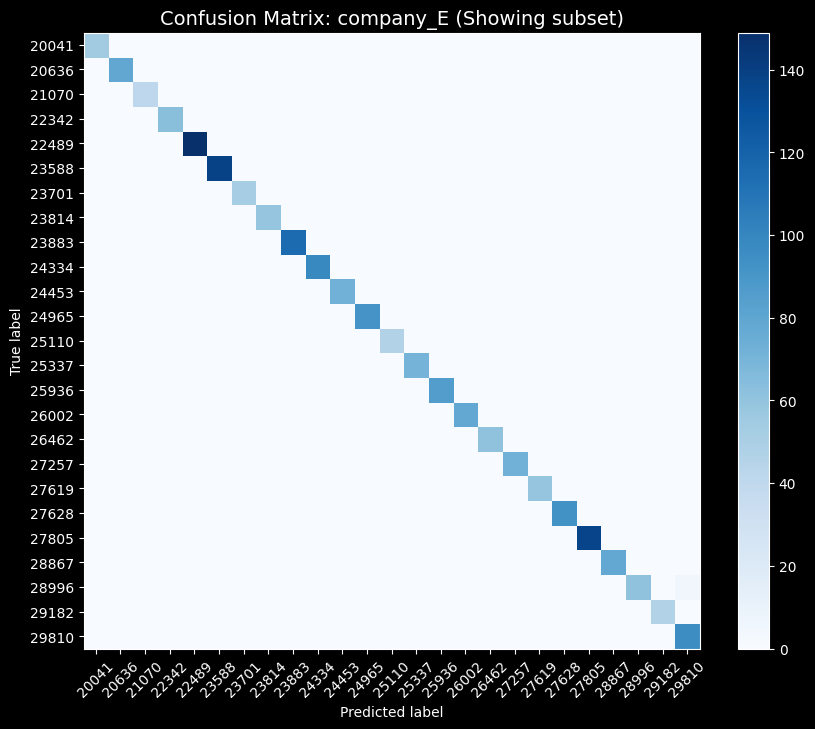

Generating Confusion Matrix for GL Types...


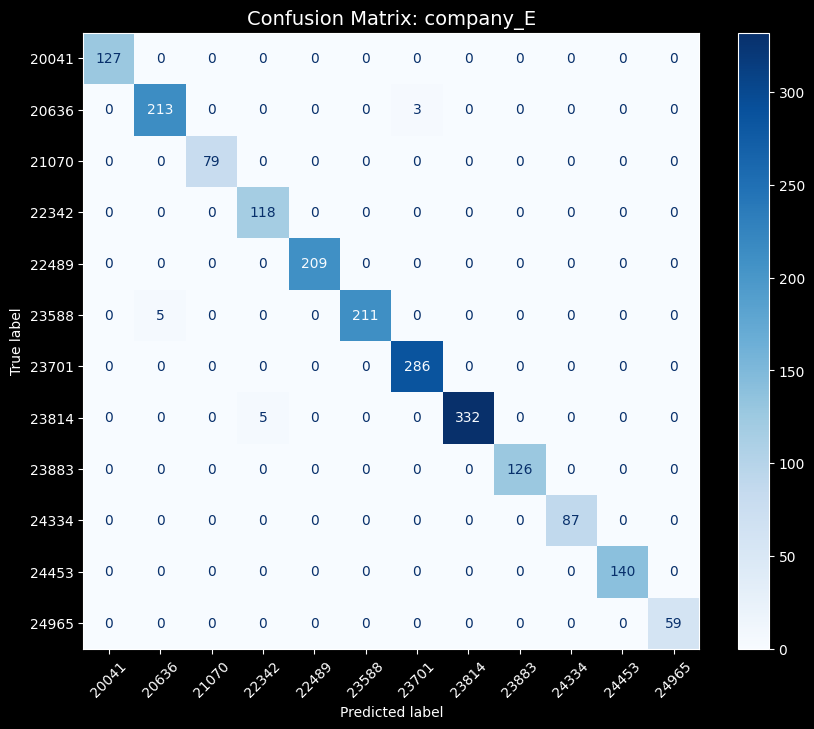

C:\Users\nishi\PythonProject\ImageForensics\.venv\Lib\site-packages\peft\tuners\tuners_utils.py:1466: UserWarning: Adapter company_E was active which is now deleted. Setting active adapter to default.
  warnings.warn(


Fetching data for company_F...
Loading cached data bundle for company_F...

--- Validating: company_F ---
Loading heads -> Types: 13, Codes: 27
Running Inference...


✅ Predictions saved to: predictions_company_F.csv

--- Prediction Sample for company_F ---
Idx   Merchant                       Act. Code            Pred. Code           Match
-------------------------------------------------------------------------------------
0     Rogers, Murray and Vega trb    67569                67569                ✅    
1     Payne-Doyle pwa                72783                72783                ✅    
2     Diaz-Yang pke                  75191                75191                ✅    
3     Simmons Group dyj              75996                75996                ✅    
4     Gilbert, Hamilton and Lee sy   74271                74271                ✅    
5     Vaughan Group xaf              67035                67035                ✅    
6     Moore, Conway and Bradley pl   74402                74402                ✅    
7     Sanchez, Estrada and Tucker    73382                73382                ✅    
8     Russell LLC rua                74775                

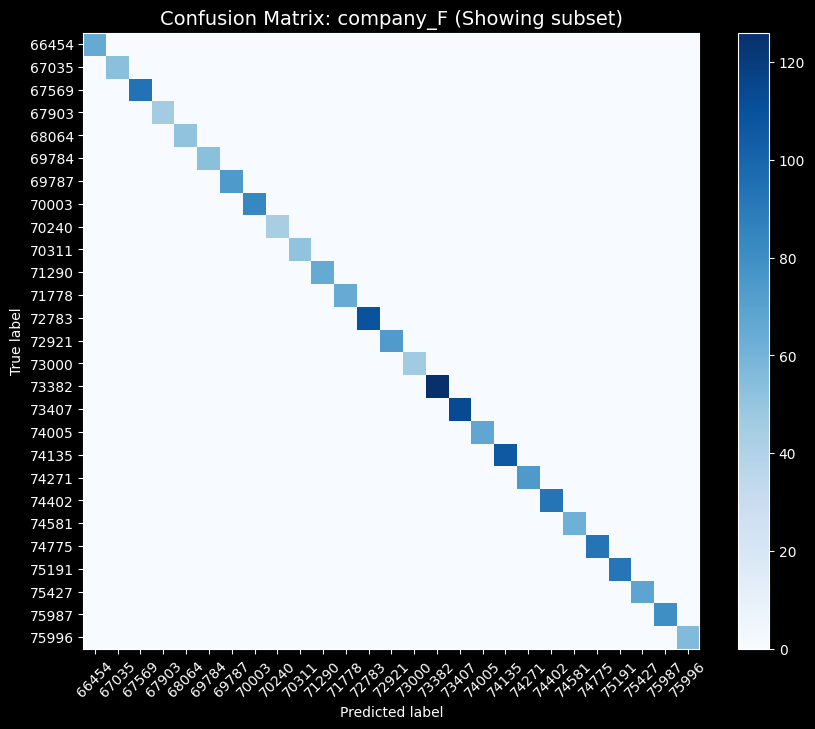

Generating Confusion Matrix for GL Types...


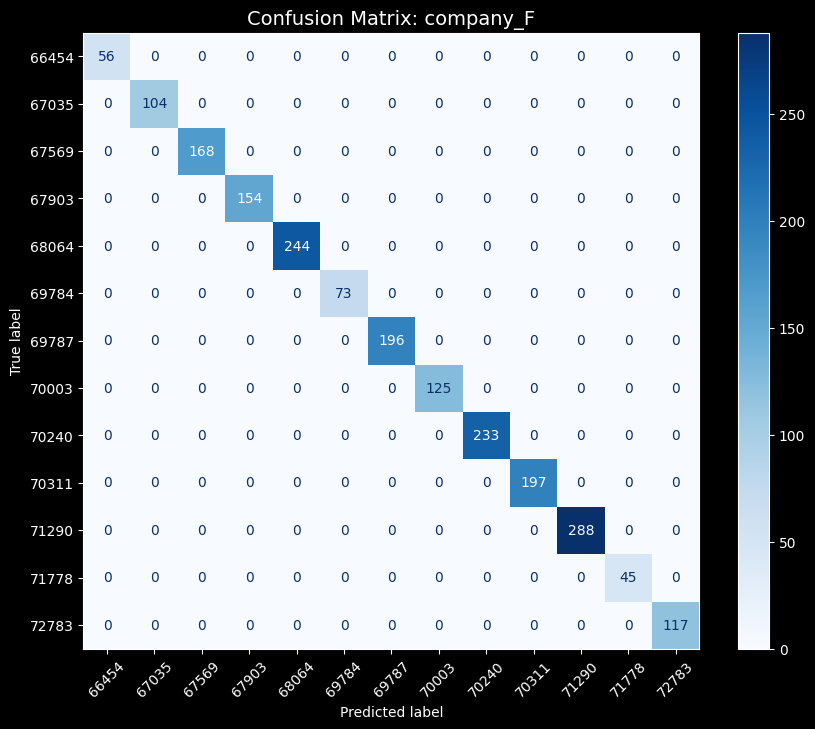


=== Final Results Summary ===
[{'company': 'company_D', 'acc_code': 0.984}, {'company': 'company_E', 'acc_code': 0.9975}, {'company': 'company_F', 'acc_code': 1.0}]


C:\Users\nishi\PythonProject\ImageForensics\.venv\Lib\site-packages\peft\tuners\tuners_utils.py:1466: UserWarning: Adapter company_F was active which is now deleted. Setting active adapter to default.
  warnings.warn(


In [8]:
import torch
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, Trainer, TrainingArguments, AutoModel
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, \
    ConfusionMatrixDisplay
import joblib

def preprocess_logits_for_metrics(logits, labels):
    if isinstance(logits, tuple):
        return logits
    return logits


# Initialize Base Model Wrapper ONCE
print("Loading Base Model (this takes time)...")
# Note: Ensure QwenMultiHeadClassifier class definition is available above this block
base_model_wrapper = QwenMultiHeadClassifier(
    model_id=model_id,
    num_type_labels=2,  # Dummy
    num_code_labels=2  # Dummy
)

# CRITICAL FIXES
base_model_wrapper.qwen.resize_token_embeddings(len(tokenizer))
base_model_wrapper.qwen = get_peft_model(base_model_wrapper.qwen, peft_config)
base_model_wrapper.to("cuda")  # Move to GPU


def plot_cm(cm, class_names, title):
    """
    Robust Confusion Matrix Plotter
    """
    # Ensure class names match the matrix size
    # If validation set is small, some classes might be missing from y_true or y_pred
    # confusion_matrix in sklearn returns a matrix of size [n_unique_labels, n_unique_labels]
    # We must trust the labels passed to it.

    fig, ax = plt.subplots(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Filter for readability if too many classes
    if len(class_names) > 20:
        plt.title(f"{title} (Showing subset)", fontsize=14)
        disp.plot(ax=ax, cmap='Blues', xticks_rotation=45, include_values=False)
    else:
        plt.title(title, fontsize=14)
        disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
    plt.show()


# --- 2. Validation Function ---
def validate_company(model, company_name, adapters_root_dir, val_dataset, val_metadata, encoders):
    print(f"\n--- Validating: {company_name} ---")
    adapter_path = os.path.join(adapters_root_dir, company_name)

    if not os.path.exists(adapter_path):
        print(f"❌ Adapter path not found: {adapter_path}")
        return None

    # A. Dynamic Head Resizing (Crucial Step)
    try:
        # Load state dicts to CPU first
        type_state = torch.load(os.path.join(adapter_path, "type_head.bin"), map_location="cpu")
        code_state = torch.load(os.path.join(adapter_path, "code_head.bin"), map_location="cpu")

        n_types = type_state['weight'].shape[0]
        n_codes = code_state['weight'].shape[0]

        print(f"Loading heads -> Types: {n_types}, Codes: {n_codes}")

        # Resize the linear layers on the model
        dtype = model.qwen.dtype
        device = model.qwen.device

        model.type_head = torch.nn.Linear(model.config.hidden_size, n_types).to(device=device, dtype=dtype)
        model.code_head = torch.nn.Linear(model.config.hidden_size, n_codes).to(device=device, dtype=dtype)

        # Load weights
        model.type_head.load_state_dict(type_state)
        model.code_head.load_state_dict(code_state)

    except FileNotFoundError:
        print(f"❌ Skipping {company_name}: Head weights (bin files) not found.")
        return None

    # B. Load LoRA Adapter
    try:
        # Only load if not already loaded (avoid duplicates error)
        if company_name not in model.qwen.peft_config:
            model.qwen.load_adapter(adapter_path, adapter_name=company_name)

        model.qwen.set_adapter(company_name)
    except Exception as e:
        print(f"❌ Skipping {company_name}: Adapter load failed. {e}")
        return None

    # C. Inference
    eval_trainer = Trainer(
        model=model,
        args=TrainingArguments(
            output_dir="./temp_eval",
            per_device_eval_batch_size=32,
            remove_unused_columns=False,
            report_to="none",
            # Optimization: Use float16 if GPU supports it
            fp16=torch.cuda.is_available()
        ),
        preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    )

    print("Running Inference...")
    preds = eval_trainer.predict(val_dataset, ignore_keys=["loss", "hidden_states", "attentions"])
    logits_type, logits_code = preds.predictions

    # D. Metrics & DataFrame Construction
    pred_types = np.argmax(logits_type, axis=1)
    pred_codes = np.argmax(logits_code, axis=1)

    # Get ground truth from Dataset (guaranteed to be aligned with inputs)
    true_types = np.array(val_dataset['labels_type'])
    true_codes = np.array(val_dataset['labels_code'])

    # Encoders for decoding
    type_encoder = encoders["type"]
    code_encoder = encoders["code"]

    # --- DATAFRAME CREATION ---
    # Important: val_metadata MUST be the exact dataframe used to create val_dataset
    # If val_dataset was shuffled independently, this will be mismatched.
    # Assuming get_company_dataset returns them aligned.

    predictions_df = pd.DataFrame({
        'merchant_name': val_metadata['merchant_name'].values,  # Use .values to ignore index mismatch
        'merchant_group': val_metadata['merchant_group'].values,
        'actual_type_str': val_metadata['cc_type'].values,
        'actual_code_str': val_metadata['cc_code'].values,
        'pred_type_id': pred_types,
        'pred_code_id': pred_codes,
        'true_type_id': true_types,
        'true_code_id': true_codes
    })

    # Add decoded strings
    # Handle cases where predicted ID might be out of range of encoder (rare bug check)
    try:
        predictions_df['pred_type_str'] = type_encoder.inverse_transform(pred_types)
        predictions_df['pred_code_str'] = code_encoder.inverse_transform(pred_codes)
    except ValueError as e:
        print(f"⚠️ Decoding Error: {e}. Check if encoders match the model training!")
        predictions_df['pred_type_str'] = "ERROR"
        predictions_df['pred_code_str'] = "ERROR"

    predictions_df['type_correct'] = predictions_df['pred_type_id'] == predictions_df['true_type_id']
    predictions_df['code_correct'] = predictions_df['pred_code_id'] == predictions_df['true_code_id']

    # Save to CSV
    output_file = f"predictions_{company_name}.csv"
    predictions_df.to_csv(output_file, index=False)
    print(f"✅ Predictions saved to: {output_file}")

    # --- PRINT SAMPLE ---
    print(f"\n--- Prediction Sample for {company_name} ---")
    print(f"{'Idx':<5} {'Merchant':<30} {'Act. Code':<20} {'Pred. Code':<20} {'Match':<5}")
    print("-" * 85)
    for idx in range(min(10, len(predictions_df))):
        row = predictions_df.iloc[idx]
        match = "✅" if row['code_correct'] else "❌"
        print(
            f"{idx:<5} {str(row['merchant_name'])[:28]:<30} {str(row['actual_code_str'])[:18]:<20} {str(row['pred_code_str'])[:18]:<20} {match:<5}")

    # --- METRICS CALCULATION ---
    # Zero Division=0 handles cases where a class is never predicted
    p_code = precision_score(true_codes, pred_codes, average='weighted', zero_division=0)
    r_code = recall_score(true_codes, pred_codes, average='weighted', zero_division=0)
    f1_code = f1_score(true_codes, pred_codes, average='weighted', zero_division=0)
    acc_code = accuracy_score(true_codes, pred_codes)

    p_type= precision_score(true_types, pred_types, average='weighted', zero_division=0)
    r_type = recall_score(true_types, pred_types, average='weighted', zero_division=0)
    f1_type = f1_score(true_types, pred_types, average='weighted', zero_division=0)
    acc_type = accuracy_score(true_types, pred_types)

    print(f"\n=== GL Codes Metrics ({company_name}) ===")
    print(f"Accuracy:  {acc_code:.4f}  {acc_type:.4f}  ")
    print(f"Precision: {p_code:.4f}  {p_type:.4f}  ")
    print(f"Recall:    {r_code:.4f}  {r_type:.4f}  ")
    print(f"F1 Score:  {f1_code:.4f}  {f1_type:.4f}  ")

    # --- CONFUSION MATRIX ---
    # Only compute if we have a manageable number of classes or for debugging
    unique_true_codes = sorted(list(set(true_codes)))
    unique_pred_codes = sorted(list(set(pred_codes)))
    all_labels_present_codes = sorted(list(set(unique_true_codes + unique_pred_codes)))

    unique_true_types = sorted(list(set(true_types)))
    unique_pred_types = sorted(list(set(pred_types)))
    all_labels_present_types = sorted(list(set(unique_true_types + unique_pred_types)))

    # We map these IDs back to strings for the plot labels
    try:
        label_names = code_encoder.inverse_transform(all_labels_present_codes)
        cm_code = confusion_matrix(true_codes, pred_codes, labels=all_labels_present_codes)
        print("Generating Confusion Matrix for GL Codes...")
        plot_cm(cm_code, label_names, f"Confusion Matrix: {company_name}")

        label_names_type = code_encoder.inverse_transform(all_labels_present_types)
        cm_code_type = confusion_matrix(true_types, pred_types, labels=all_labels_present_types)
        print("Generating Confusion Matrix for GL Types...")
        plot_cm(cm_code_type, label_names_type, f"Confusion Matrix: {company_name}")

    except Exception as e:
        print(f"⚠️ Could not plot confusion matrix: {e}")

    # E. Cleanup
    try:
        # Delete adapter to free memory for next company
        model.qwen.delete_adapter(company_name)
    except:
        pass  # Ignore if delete fails

    torch.cuda.empty_cache()  # Clear GPU memory

    return {"company": company_name, "acc_code": acc_code}


# --- 3. Execution Loop ---
results = []
companies = ["company_D",  "company_E", "company_F"]  # Add "company_E", "company_F" as needed

for company in companies:
    # 1. Get Data Bundle (Ensure this returns 'val', 'val_metadata', 'encoders')
    print(f"Fetching data for {company}...")
    bundle_path = f"data_bundle_{company}.pkl"

    if os.path.exists(bundle_path):
        print(f"Loading cached data bundle for {company}...")
        data_bundle = joblib.load(bundle_path)


    # 2. Validate
    res = validate_company(
        model=base_model_wrapper,
        company_name=company,
        adapters_root_dir="./final_adapters_QWEN",
        val_dataset=data_bundle['val'],
        val_metadata=data_bundle["val_metadata"],
        encoders=data_bundle["encoders"]
    )

    if res:
        results.append(res)


print("\n=== Final Results Summary ===")
print(results)
